<a href="https://colab.research.google.com/github/Heisenberg0203/ML_Home_Credit_RISK/blob/master/Malware_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"rushikesh0203","key":"a57a54502e5e03998e7362e6218d1695"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c malware-prediction-tm -p /content

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip \*.zip

Archive:  sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                

3 archives were successfully processed.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
import gc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
sns.set_style('darkgrid')
%matplotlib inline

In [8]:
application_train = pd.read_csv("/content/train.csv")
application_test = pd.read_csv("/content/test.csv")


In [9]:
print("Application Shape: ", application_train.shape)
print("Application Shape: ", application_test.shape)

Application Shape:  (567730, 83)
Application Shape:  (243313, 82)


In [10]:
application_train.columns.to_list()

['MachineIdentifier',
 'ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 

In [11]:
pd.set_option('max_columns', None)
application_train.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,47251fee0e1dd5a339109b3eb2fa5f9b,win8defender,1.1.15100.1,4.18.1807.18075,1.273.810.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,35,125514.0,NaN,45.0,83,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2668.0,171230.0,2.0,5.0,1992.0,NaN,59640.0,SSD,58362.0,0,2048.0,Notebook,13.9,1360.0,768.0,Mobile,lion,4.350000e+02,10.0.17134.191,amd64,rs4_release,17134,191,Core,CORE,Update,8.0,31,FullAuto,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,0.0,644.0,31826.0,1,0.0,0.0,0,0,0.0,0.0,4.0,0
1,f5eb5c817e66cee3dc2f87919e68fd2b,win8defender,1.1.15300.6,4.18.1806.18062,1.277.4.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,160,74509.0,18.0,204.0,170,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,NaN,NaN,111.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2102.0,229904.0,2.0,5.0,1992.0,NaN,476940.0,HDD,460920.0,0,4096.0,Notebook,15.5,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.16299.248,amd64,rs3_release,16299,248,Core,CORE,Update,7.0,115,Notify,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,554.0,33100.0,0,NaN,0.0,0,0,0.0,0.0,12.0,0
2,91aecab8cb2228b55b0deaf0b4b9700a,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1208.0,0,7.0,0,NaN,68585.0,2.0,1.0,1,43,134641.0,27.0,53.0,42,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,525.0,331221.0,8.0,5.0,3104.0,NaN,228936.0,SSD,118217.0,0,12288.0,Notebook,15.5,1920.0,1080.0,Mobile,NaN,3.600000e+01,10.0.17134.191,amd64,rs4_release,17134,191,CoreCountrySpecific,CORE_COUNTRYSPECIFIC,IBSClean,37.0,158,FullAuto,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,142.0,69970.0,1,NaN,0.0,0,0,0.0,1.0,7.0,0
3,5695d2e5af0d71586dae387493ff87ed,win8defender,1.1.15200.1,4.18.1807.18075,1.275.190.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,68,12784.0,27.0,276.0,74,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,Off,1.0,1.0,Notebook,Windows.Desktop,2102.0,245824.0,4.0,5.0,2393.0,NaN,953869.0,HDD,938399.0,0,8192.0,Notebook,15.5,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.17134.228,amd64,rs4_release,17134,228,Core,CORE,Refresh,7.0,3

In [12]:
pd.reset_option('max_columns')

In [13]:
application_train.describe()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,567730.000000,565530.000000,567730.000000,29185.000000,564967.000000,564967.000000,564967.000000,567730.000000,567730.000000,546726.000000,392122.000000,567710.000000,567730.00000,567730.000000,567730.000000,564981.000000,567730.000000,529533.000000,564166.000000,561894.000000,567052.000000,561454.000000,561043.000000,565276.000000,565276.000000,565275.000000,5.644610e+05,5.644630e+05,567730.000000,562434.000000,564821.000000,564836.000000,564836.000000,5.513410e+05,567730.000000,567730.000000,563984.000000,567730.000000,567730.000000,97702.000000,557525.000000,209261.000000,554833.000000,556428.000000,567730.000000,209766.0,566716.000000,567730.000000,567730.000000,563254.000000,549003.000000,549003.000000,567730.000000
mean,0.000009,6.814935,0.020622,1662.359637,46683.401057,1.381688,1.026055,0.987617,107.746922,81367.930537,24.852995,169.398834,122.08138,15678.416004,578.955796,0.936315,0.000028,0.000714,126.073269,0.978377,0.994955,2234.851393,239333.816087,3.909634,4.523852,2356.678882,5.004740e+05,3.739335e+05,0.073554,5899.040152,16.522856,1538.965514,895.292184,1.097640e+09,15790.215537,996.213441,14.587366,60.390515,0.000498,0.000010,0.000011,0.000210,406.975618,33021.268775,0.486814,0.0,0.009926,0.135073,0.040995,0.067650,0.267000,7.949663,0.149999
std,0.002968,1.112039,0.142117,985.761456,15296.279454,0.552679,0.185890,0.110586,62.929557,48923.657357,5.526169,89.200893,68.78134,2206.790427,247.071576,0.244192,0.005309,0.026708,42.823436,0.145450,0.221268,1325.021522,71804.861272,2.052268,1.296193,848.278593,3.796903e+05,3.263121e+05,0.261044,5076.542665,5.892315,369.883842,217.365480,1.873371e+09,1983.018804,2966.512058,10.170373,44.843672,0.022321,0.003199,0.003281,0.014499,222.263960,21206.538347,0.499827,0.0,0.099132,0.341802,0.198278,0.251144,0.442393,4.554193,0.357071
min,0.000000,0.000000,0.000000,1.000000,16.000000,1.000000,0.000000,0.000000,1.000000,7.000000,1.000000,1.000000,1.00000,7600.000000,16.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,22.000000,1.000000,1.000000,3.000000,0.000000e+00,0.000000e+00,0.000000,512.000000,3.000000,-1.000000,-1.000000,0.000000e+00,7600.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,9.000000,3.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,7.000000,0.000000,788.000000,47238.000000,1.000000,1.000000,1.000000,51.000000,36825.000000,18.000000,89.000000,74.00000,15063.000000,256.000000,1.000000,0.000000,0.000000,108.000000,1.000000,1.000000,1443.000000,189767.000000,2.000000,5.000000,1998.000000,2.384750e+05,1.197550e+05,0.000000,4096.000000,13.900000,1366.000000,768.000000,0.000000e+00,15063.000000,167.000000,8.000000,31.000000,0.00

In [14]:
def getCnamesNumeric(df):
    return list(df.select_dtypes(exclude='object').columns)

def getCnamesObject(df):
    return list(df.select_dtypes(include='object').columns)

def getDetailsAboutMissingValuesAllColumns(df):
  return df.isna().sum()/df.shape[0]

def getDetailsAboutOnlyMissingValuesColumns(df):
  print("Shape: ", df.shape)
  return df[list(df.columns[df.isna().any()])].isna().sum()/df.shape[0]

def dropColumns(df, columnNames):
  for column in columnNames:
    df = df.drop(column, axis = 1)
  return df

def imputeCategoricalMissingValuesUsingMode(df):
  columnName = getCnamesObject(df)
  for col in columnName: df[col].fillna(df[col].mode().values[0], inplace = True)

def imputeNumericMissingValuesUsingMean(df):
  columnName = getCnamesNumeric(df)
  for col in columnName: df[col].fillna(df[col].mean(), inplace = True)

def plotCountPlotForCategoricalFeatures(df, cnamesObject):
  number_of_rows = (len(cnamesObject) + 1)/2
  plt.figure(figsize=(20, 6*number_of_rows))

  for i in range(0,len(cnamesObject)):
    plt.subplot(number_of_rows,2,i+1)
    sns.countplot(y=cnamesObject[i], data = df)
    plt.title(cnamesObject[i])
    plt.tight_layout()

def distributionOfCategoricalFeaturesWRTTarget(df, cnamesObject):
  number_of_rows = (len(cnamesObject) + 1)/2
  plt.figure(figsize=(20, 6*number_of_rows))

  for i in range(0,len(cnamesObject)):
    plt.subplot(number_of_rows,2,i+1)
    sns.countplot(data=df, hue="TARGET", y=cnamesObject[i])
    plt.title(cnamesObject[i])
    plt.tight_layout()

def drawCorrelationMatrix(df) :
  length = len(getCnamesNumeric(df))
  correlaionMatrix = df.corr()
  plt.figure(figsize=(length,length*0.8))
  sns.heatmap(correlaionMatrix, annot=True, cmap = 'viridis')

def drawDistributionPlot(df, cnamesNumeric):
  number_of_rows = (len(cnamesNumeric) + 1)/2
  plt.figure(figsize=(20, 4*number_of_rows))

  for i in range(0, len(cnamesNumeric)):
    plt.subplot(number_of_rows,3,i+1)
    sns.kdeplot(df[cnamesNumeric[i]])
    plt.title(cnamesNumeric[i])
    plt.tight_layout()

def corr_columnwise(df):
  columns = df.columns
  for col in columns:
    at_corr_col = at_corr[col]
    print(col+" +ve")
    print(at_corr_col[at_corr_col>0.9].index.to_list())
    print(col+" -ve")
    print(at_corr_col[at_corr_col<-0.9].index.to_list())

def remove_corr_columns(df,atNC,atCC,df_corr):
  threshold = 0.9
  columns = np.full((df_corr.shape[0],), True, dtype=bool)
  for i in range(df_corr.shape[0]):
      for j in range(i+1, df_corr.shape[0]):
          if df_corr.iloc[i,j] >= threshold:
              if columns[j]:
                  columns[j] = False
  x_temp=df[atNC].columns[columns].to_list()
  return pd.concat([df[x_temp],df[atCC]],axis=1)

def checkOutlier(data, cnames_numeric):
    number_of_rows = (len(cnames_numeric) + 1)/2
    plt.figure(figsize=(20, 4*number_of_rows))
    
    for i in range(0,len(cnames_numeric)):
        plt.subplot(number_of_rows,4,i+1)
        sns.boxplot(x=data[cnames_numeric[i]])
        plt.title(cnames_numeric[i])
        plt.tight_layout()

def removeOutlier(data, cnamesNumeric):
    for i in cnamesNumeric:
        q75, q25 = np.percentile(data.loc[:,i], [75 ,25])
        #Calculate IQR
        iqr = q75 - q25
        #Calculate inner and outer fence
        minimum = q25 - (iqr*1.5)
        maximum = q75 + (iqr*1.5)
        #Replace with NA
        data.loc[data.loc[:,i] < minimum,i] = np.nan
        data.loc[data.loc[:,i] > maximum,i] = np.nan
    imputeNumericMissingValuesUsingMean(data)
    return data

def drawPieChartForCategoricalFeatures(df, columnNames):
  number_of_rows = int((len(columnNames) + 1)/2)
  plt.figure(figsize=(20, 6*number_of_rows))

  for i in range(0,len(columnNames)):
    col = columnNames[i]
    percentage = (df[col].value_counts(dropna=True, normalize=True)*100).to_list()
    labels = list(df[col].unique())
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percentage)]
    sizes = list(df[col].value_counts(dropna=True))
    ax1 = plt.subplot(number_of_rows,2,i + 1)
    wedges, autotexts = ax1.pie(sizes, startangle=90)
    #ax1.axis('equal')

    ax1.legend(wedges, labels,
              title=col,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title(col)
plt.show()

def applyOneHotEncoding(df, Columns):
  for col in Columns:
    ohc = OneHotEncoder()
    ohe = ohc.fit_transform(df[col].values.reshape(-1,1)).toarray()
    dfOneHot = pd.DataFrame(ohe, columns=[col+"_"+str(ohc.categories_[0][i])
                                                for i in range(len(ohc.categories_[0]))])
    df = pd.concat([df, dfOneHot.reindex(df.index)], axis=1)
    df = df.drop(col, axis = 1)
  return df
  
def plot_feature_importances(df):
    
    df = df.sort_values('importance', ascending = False).reset_index()
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    ax.barh(list(reversed(list(df.index[:10]))), df['importance_normalized'].head(10))

    ax.set_yticks(list(reversed(list(df.index[:10]))))
    ax.set_yticklabels(df['feature'].head(10))
  
    plt.xlabel('Percentage'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [15]:
atCC = getCnamesObject(application_train)
print("Number of categorical columns in application_train: ", len(atCC), "\n", atCC)

atNC = getCnamesNumeric(application_train)
print("Number of numerical columns in application_train: ", len(atNC), "\n", atNC)

atestCC = getCnamesObject(application_test)
print("Number of categorical columns in application_test: ", len(atestCC), "\n", atestCC)

atestNC = getCnamesNumeric(application_test)
print("Number of numerical columns in application_test: ", len(atestNC), "\n", atestNC)

Number of categorical columns in application_train:  30 
 ['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'Platform', 'Processor', 'OsVer', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'PuaMode', 'SmartScreen', 'Census_MDC2FormFactor', 'Census_DeviceFamily', 'Census_ProcessorClass', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_InternalBatteryType', 'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel', 'Census_FlightRing']
Number of numerical columns in application_train:  53 
 ['IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode', 'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm', 'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier', 'Local

In [16]:
atCC.remove('MachineIdentifier')
atestCC.remove('MachineIdentifier')

In [17]:
application_train[atCC]

,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,PuaMode,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_ProcessorClass,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.810.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,NaN,RequireAdmin,Notebook,Windows.Desktop,NaN,SSD,Notebook,Mobile,lion,10.0.17134.191,amd64,rs4_release,Core,CORE,Update,FullAuto,IS_GENUINE,OEM:DM,Retail
1,win8defender,1.1.15300.6,4.18.1806.18062,1.277.4.0,windows10,x64,10.0.0.0,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,NaN,RequireAdmin,Notebook,Windows.Desktop,NaN,HDD,Notebook,Mobile,NaN,10.0.16299.248,amd64,rs3_release,Core,CORE,Update,Notify,IS_GENUINE,OEM:DM,Retail
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1208.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,NaN,NaN,Notebook,Windows.Desktop,NaN,SSD,Notebook,Mobile,NaN,10.0.17134.191,amd64,rs4_release,CoreCountrySpecific,CORE_COUNTRYSPECIFIC,IBSClean,FullAuto,IS_GENUINE,OEM:DM,Retail
3,win8defender,1.1.15200.1,4.18.1807.18075,1.275.190.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,NaN,Off,Notebook,Windows.Desktop,NaN,HDD,Notebook,Mobile,NaN,10.0.17134.228,amd64,rs4_release,Core,CORE,Refresh,FullAuto,IS_GENUINE,OEM:DM,Retail
4,win8defender,1.1.15200.1,4.18.1807.18075,1.275.497.0,windows10,x64,10.0.0.0,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Pro,NaN,RequireAdmin,Desktop,Windows.Desktop,NaN,HDD,Desktop,Desktop,NaN,10.0.16299.547,amd64,rs3_release_svc_escrow,Professional,PROFESSIONAL,UUPUpgrade,AutoInstallAndRebootAtMaintenanceTime,IS_GENUINE,Retail,Retail
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567725,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1732.0,windows10,x64,10.0.0.0,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,NaN,RequireAdmin,Notebook,Windows.Desktop,NaN,HDD,Notebook,Mobile,lion,10.0.16299.309,amd64,rs3_release,CoreSingleLanguage,CORE_SINGLELANGUAGE,Update,Notify,IS_GENUINE,OEM:DM,Retail
567726,mse,1.1.15100.1,4.10.209.0,1.273.428.0,windows7,x64,6.1.1.0,windows7,7601.23572.amd64fre.win7sp1_ldr.161011-0600,Pro,NaN,NaN,Desktop,Windows.Desktop,mid,HDD,Desktop,Desktop,NaN,10.0.14393.576,amd64,rs1_release,Professional,PROFESSIONAL,Update,FullAuto,IS_GENUINE,Retail,Retail
567727,win8defender,1.1.15200.1,4.18.1806.18062,1.275.438.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,NaN,RequireAdmin,Desktop,Windows.Desktop,NaN,SSD,Desktop,Desktop,NaN,10.0.17134.112,amd64,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,Notify,IS_GENUINE,Retail,Retail
567728,win8defender,1.1.15200.1,4.8.10240.17443,1.275.1458.0,windows10,x86,10.0.0.0,th1,10240.17443.x86fre.th1.170602-2340,Pro,NaN,RequireAdmin,Notebook,Windows.Desktop,NaN,HDD,Portable,Mobile,lion,10.0.10240.17443,x86,th1,Professional,PROFESSIONAL,IBSClean,UNKNOWN,INVALID_LICENSE,Retail,NOT_SET


In [18]:
application_train.nunique().sort_values(ascending=False)

MachineIdentifier                   567730
Census_SystemVolumeTotalCapacity    152140
Census_OEMModelIdentifier            44717
CityIdentifier                       39604
Census_FirmwareVersionIdentifier     25112
                                     ...  
Firewall                                 2
SMode                                    2
HasDetections                            2
Census_IsWIMBootEnabled                  1
PuaMode                                  1
Length: 83, dtype: int64

In [19]:
#plotCountPlotForCategoricalFeatures(application_train, atCC)

In [20]:
#distributionOfCategoricalFeaturesWRTTarget(application_train, atCC)

In [21]:
#drawDistributionPlot(application_train, atNC)

In [22]:
#drawCorrelationMatrix(application_train)

In [23]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

at_corr=application_train.corr()

In [24]:
corr_columnwise(application_train.corr())

IsBeta +ve
['IsBeta']
IsBeta -ve
[]
RtpStateBitfield +ve
['RtpStateBitfield']
RtpStateBitfield -ve
[]
IsSxsPassiveMode +ve
['IsSxsPassiveMode']
IsSxsPassiveMode -ve
[]
DefaultBrowsersIdentifier +ve
['DefaultBrowsersIdentifier']
DefaultBrowsersIdentifier -ve
[]
AVProductStatesIdentifier +ve
['AVProductStatesIdentifier']
AVProductStatesIdentifier -ve
[]
AVProductsInstalled +ve
['AVProductsInstalled']
AVProductsInstalled -ve
[]
AVProductsEnabled +ve
['AVProductsEnabled']
AVProductsEnabled -ve
[]
HasTpm +ve
['HasTpm']
HasTpm -ve
[]
CountryIdentifier +ve
['CountryIdentifier']
CountryIdentifier -ve
[]
CityIdentifier +ve
['CityIdentifier']
CityIdentifier -ve
[]
OrganizationIdentifier +ve
['OrganizationIdentifier']
OrganizationIdentifier -ve
[]
GeoNameIdentifier +ve
['GeoNameIdentifier']
GeoNameIdentifier -ve
[]
LocaleEnglishNameIdentifier +ve
['LocaleEnglishNameIdentifier']
LocaleEnglishNameIdentifier -ve
[]
OsBuild +ve
['OsBuild', 'Census_OSBuildNumber']
OsBuild -ve
[]
OsSuite +ve
['OsSuite'

In [25]:
pd.reset_option('max_columns')
pd.reset_option('max_rows')

In [26]:
new_application_train = remove_corr_columns(application_train,atNC,atCC,at_corr)

In [27]:
labels = new_application_train['HasDetections']

new_application_train, new_application_test = new_application_train.align(application_test, join = 'inner', axis = 1)

new_application_train['HasDetections'] = labels

print('Training Features shape: ', new_application_train.shape)
print('Testing Features shape: ', new_application_test.shape)

Training Features shape:  (567730, 80)
Testing Features shape:  (243313, 79)


In [28]:
print(getDetailsAboutOnlyMissingValuesColumns(new_application_train).sort_values(ascending=False))
print(getDetailsAboutOnlyMissingValuesColumns(new_application_test).sort_values(ascending=False))

Shape:  (567730, 80)
PuaMode                                              0.999792
Census_ProcessorClass                                0.996268
DefaultBrowsersIdentifier                            0.948594
Census_IsFlightingInternal                           0.827908
Census_InternalBatteryType                           0.705353
Census_ThresholdOptIn                                0.631408
Census_IsWIMBootEnabled                              0.630518
SmartScreen                                          0.365727
OrganizationIdentifier                               0.309316
SMode                                                0.067280
CityIdentifier                                       0.036996
Wdft_RegionIdentifier                                0.032986
Wdft_IsGamer                                         0.032986
Census_InternalBatteryNumberOfCharges                0.028868
Census_FirmwareManufacturerIdentifier                0.022717
Census_FirmwareVersionIdentifier                 

In [29]:
missing_value_cols=getDetailsAboutOnlyMissingValuesColumns(new_application_train).sort_values(ascending=False)
drop_cols=missing_value_cols[missing_value_cols>0.6].index.to_list()

Shape:  (567730, 80)


In [30]:
new_application_train = new_application_train.drop(drop_cols,axis=1)
new_application_test = new_application_test.drop(drop_cols,axis=1)

In [31]:
print(getDetailsAboutOnlyMissingValuesColumns(new_application_train).sort_values(ascending=False))
print(getDetailsAboutOnlyMissingValuesColumns(new_application_test).sort_values(ascending=False))

Shape:  (567730, 73)
SmartScreen                                          0.365727
OrganizationIdentifier                               0.309316
SMode                                                0.067280
CityIdentifier                                       0.036996
Wdft_RegionIdentifier                                0.032986
Wdft_IsGamer                                         0.032986
Census_InternalBatteryNumberOfCharges                0.028868
Census_FirmwareManufacturerIdentifier                0.022717
Census_FirmwareVersionIdentifier                     0.019907
Census_IsFlightsDisabled                             0.017975
Census_OEMModelIdentifier                            0.011778
Census_OEMNameIdentifier                             0.011055
Firewall                                             0.010280
Census_TotalPhysicalRAM                              0.009328
Census_IsAlwaysOnAlwaysConnectedCapable              0.007884
Census_OSInstallLanguageIdentifier               

In [32]:
imputeCategoricalMissingValuesUsingMode(new_application_train)
imputeNumericMissingValuesUsingMean(new_application_train)

imputeCategoricalMissingValuesUsingMode(new_application_test)
imputeNumericMissingValuesUsingMean(new_application_test)

In [33]:
atCC = getCnamesObject(new_application_train)

atNC = getCnamesNumeric(new_application_train)

atestCC = getCnamesObject(new_application_test)

atestNC = getCnamesNumeric(new_application_test)


In [34]:
#checkOutlier(new_application_train, atNC)

In [35]:
#Extract out target variable
dfTarget = new_application_train.HasDetections
new_application_train = new_application_train.drop('HasDetections', axis = 1)

In [42]:
atNC = getCnamesNumeric(new_application_train)
atCC = getCnamesObject(new_application_train)

In [43]:
new_application_train = removeOutlier(new_application_train, atNC)

#######################Exploring Categorical Variable########################

In [44]:
new_application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0).sort_values()

Census_DeviceFamily                    3
Census_OSArchitecture                  3
Processor                              3
Census_GenuineStateName                4
Platform                               4
Census_PrimaryDiskTypeName             4
Census_OSWUAutoUpdateOptionsName       6
Census_ActivationChannel               6
ProductName                            6
SkuEdition                             8
Census_FlightRing                      8
OsPlatformSubRelease                   9
Census_PowerPlatformRoleName           9
Census_OSInstallTypeName               9
SmartScreen                           11
Census_MDC2FormFactor                 12
Census_OSBranch                       17
OsVer                                 19
Census_OSSkuName                      20
Census_OSEdition                      23
Census_ChassisTypeName                32
EngineVersion                         54
AppVersion                            94
Census_OSVersion                     299
OsBuildLab      

In [45]:
atCCTemp = atCC
atCCTemp.remove('AvSigVersion')
atCCTemp.remove('OsBuildLab')
atCCTemp.remove('Census_OSVersion')
atCCTemp.remove('AppVersion')
atCCTemp.remove('EngineVersion')
atCCTemp.remove('Census_ChassisTypeName')



# drawPieChartForCategoricalFeatures(new_application_train, atCCTemp)

In [56]:
# drawPieChartForCategoricalFeatures(new_application_train, ['OCCUPATION_TYPE','ORGANIZATION_TYPE'])

In [46]:
dfTarget.value_counts(dropna=True, normalize=True)*100

0    85.000088
1    14.999912
Name: HasDetections, dtype: float64

In [47]:
new_application_train_Temp = applyOneHotEncoding(new_application_train, atCCTemp)
new_application_test_Temp = applyOneHotEncoding(new_application_test, atCCTemp)

In [49]:
new_application_train_Temp = new_application_train_Temp.drop(['AvSigVersion','OsBuildLab','Census_OSVersion','AppVersion','EngineVersion','Census_ChassisTypeName'], axis = 1)

In [50]:
new_application_train_Temp = remove_corr_columns(new_application_train_Temp,
                                                  getCnamesNumeric(new_application_train_Temp),
                                                  getCnamesObject(new_application_train_Temp),
                                                  new_application_train_Temp.corr())

In [51]:
new_application_train_Temp, new_application_test_Temp = new_application_train_Temp.align(new_application_test_Temp, join = 'inner', axis = 1)

print('Training Features shape: ', new_application_train_Temp.shape)
print('Testing Features shape: ', new_application_test_Temp.shape)

Training Features shape:  (567730, 175)
Testing Features shape:  (243313, 175)


In [52]:
train = new_application_train_Temp.copy()
test = new_application_test_Temp.copy()
train_labels = labels.copy()
features = list(train.columns)

In [53]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(train)
train = sc.transform(train)
test = sc.transform(test)

In [65]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

random_forest.fit(train, train_labels)

feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished


In [94]:
predictions_1 = random_forest.predict_proba(test.drop('MachineIdentifier',axis=1))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.1s finished


In [104]:
pd.Series(predictions_1[:,0])

0         0.60
1         0.63
2         0.62
3         0.67
4         0.61
          ... 
243308    0.59
243309    0.51
243310    0.65
243311    0.66
243312    0.60
Length: 243313, dtype: float64

In [105]:
feature_importances.sort_values('importance', ascending = False)[:10]

,feature,importance
8,CityIdentifier,2234.0
26,Census_SystemVolumeTotalCapacity,2188.8
24,Census_ProcessorModelIdentifier,1914.2
38,Census_FirmwareVersionIdentifier,1882.6
21,Census_OEMModelIdentifier,1764.4
33,Census_OSBuildRevision,1763.8
7,CountryIdentifier,1724.6
11,LocaleEnglishNameIdentifier,1410.1
10,GeoNameIdentifier,1179.7
45,Wdft_RegionIdentifier,1010.1


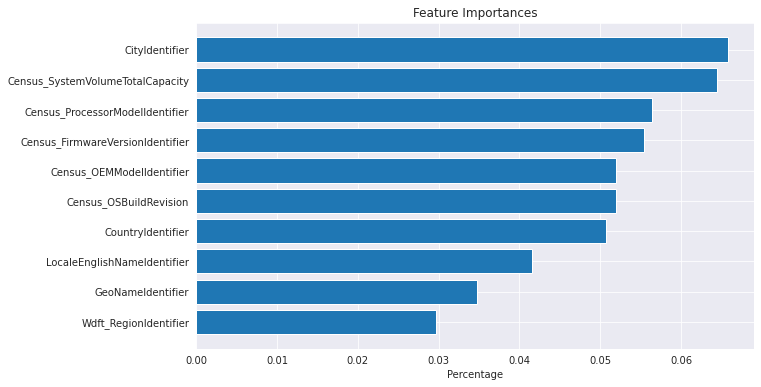

In [106]:
feature_importances_sorted = plot_feature_importances(feature_importances)

In [107]:
submission_1 = pd.DataFrame({'MachineIdentifier': application_test.MachineIdentifier, 'HasDetections': predictions_1[:,0]})

In [108]:
submission_1.to_csv("Elite_3_rf.csv",index=False)

In [109]:
submission_1.head()

,MachineIdentifier,HasDetections
0,8eaec422887bd1b29c46b03a556fff4b,0.60
1,f341efde83ba70ebd76098333005cf99,0.63
2,d631aed611b0bbf75af5a8c1f2beeca9,0.62
3,8c0af3f4b21d75149b101f5ee5921a8a,0.67
4,4117d18415fb244d797199bd8902d09b,0.61


In [81]:
train = new_application_train_Temp.copy()
test = new_application_test_Temp.copy()
train_labels = labels.copy()
features = list(train.columns)

In [83]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier

In [84]:
labels[labels==0].shape,labels[labels==1].shape

((482571,), (85159,))

In [125]:
def model(features, test_features, encoding = 'ohe', n_folds = 10):
    # Extract the ids
    train_ids = features['MachineIdentifier']
    test_ids = test_features['MachineIdentifier']
    
    # Extract the labels for training
    labels = features['HasDetections']
    
    # Remove the ids and target
    features = features.drop(columns = ['MachineIdentifier', 'HasDetections'])
    test_features = test_features.drop(columns = ['MachineIdentifier'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        # model = lgb.LGBMClassifier(n_estimators=30000, objective = 'binary',
        #                            class_weight = 'balanced', learning_rate = 0.03,
        #                            reg_alpha = 0.01, reg_lambda = 0.01, n_jobs = -1, random_state = 50)

        
        # model = lgb.LGBMClassifier(n_estimators=100000, objective = 'binary',
        #                          class_weight = 'balanced', learning_rate = 0.05,num_leaves = 255,
        #                          reg_alpha = 0.01, reg_lambda = 0.01, n_jobs = -1, random_state = 50)
        model = lgb.LGBMClassifier(n_estimators=300000, objective = 'binary',scale_pos_weight=9,boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05,num_leaves = 255,
                                   reg_alpha = 0.01, reg_lambda = 0.01, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'MachineIdentifier': test_ids, 'HasDetections': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [126]:
train['HasDetections'] = labels
train['MachineIdentifier'] = application_train.MachineIdentifier
test['MachineIdentifier'] = application_test.MachineIdentifier

submission, feature_importances, metrics = model(train, test)

Training Data Shape:  (567730, 175)
Testing Data Shape:  (243313, 175)
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	train's binary_logloss: 0.69126	train's auc: 0.672924	valid's binary_logloss: 0.717993	valid's auc: 0.666832
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	train's binary_logloss: 0.691235	train's auc: 0.675077	valid's binary_logloss: 0.717835	valid's auc: 0.664545
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	train's binary_logloss: 0.691285	train's auc: 0.673426	valid's binary_logloss: 0.718008	valid's auc: 0.672959
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	train's binary_logloss: 0.691273	train's auc: 0.671859	valid's binary_logloss: 0.717992	valid's auc: 0.666136
Training until validation scores don't improve for 100 rounds.
Early stopping, bes

In [127]:

metrics

,fold,train,valid
0,0,0.672924,0.666832
1,1,0.675077,0.664545
2,2,0.673426,0.672959
3,3,0.671859,0.666136
4,4,0.672982,0.672338
5,5,0.674385,0.664757
6,6,0.672420,0.667643
7,7,0.672685,0.666109
8,8,0.674251,0.672641
9,9,0.673121,0.667307


In [128]:
submission.to_csv("Elite_5_lgbm_withpenalise2.csv",index = False)

In [131]:
submission['HasDetections']=(submission['HasDetections']+pd.read_csv("Elite_5_lgbm_withpenalise.csv")['HasDetections'])/2

In [132]:
submission.to_csv("Elite_5_lgbm_withpenalise_avg.csv",index = False)